# Step 3: Preprocessing

In the previous notebooks I added a series of explanatory features from Google Earth Engine and other spatial sources to the wildfires dataset based on location and time, and performed exploratory data analysis. In this notebook I preform a few data transformation to prepare the data for modelling.

Note that other preprocessing steps such as dummy-encoding of categorical variables and the train/test split occur in the modelling notebook (because it some cases they need to be embedded within pipelines).        

In [7]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# import wrangled and enriched wildfires dataset
wfs = pd.read_csv('Datasets/wildfires_withvars.csv')

In [35]:
target_feature = ['FIRE_SIZE_CLASS']

# list of continuous explanatory features
exp_cont = ['LATITUDE', 'LONGITUDE','DISCOVERY_DOY','elevation', 'slope', 'aspect', 'mean_monthly_ppt',
            'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000','usda_bp',
            'usda_fi1', 'usda_fi2', 'usda_fi3', 'usda_fi4','monthly_large_wf']

# list of categorical explanatory features
exp_cat = ['DISCOVERY_MONTH','WHR10NAME', 'aspect_cat','NA_L2NAME','US_L3NAME']

In [36]:
#override negative elevations to be 0 (to avoid scaling issues later on)
wfs.elevation = wfs.elevation.clip(lower=0)

In [37]:
#dropping all records with Fire Size Class of A
wfs = wfs[wfs.FIRE_SIZE_CLASS != 'A']

## Transforming Continuous Variables to Reduce Skew

In [39]:
# get summary statistics + skew/kurtosis for each continuous feature
wfs_describe = wfs[exp_cont].describe().T
wfs_describe['skew'] = wfs[wfs_describe.index].skew()
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_describe['skew_class'] = pd.cut(abs(wfs_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_describe['kurtosis'] = wfs[wfs_describe.index].kurtosis()

In [40]:
# shifting values so there are no negative/0 values
# by adding absolute value of min val to columns with mins <=0
# this is to allow variables to be log transformed
wfs_no_zeros = wfs[exp_cont]
for col in wfs_no_zeros.columns:
    if wfs_no_zeros[col].min() <= 0:
        wfs_no_zeros.loc[:,col] = wfs_no_zeros[col] + abs(wfs_no_zeros[col].min()) + 0.0001

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [41]:
# get summary statistics + skew/kurtosis for each continuous feature (now that feature vales are shifted)
wfs_noZ_describe = wfs_no_zeros.describe().T
wfs_noZ_describe['skew'] = wfs[wfs_noZ_describe.index].skew()

# assign "skew classes" based on general rule of thumb for interpreting skew values
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_noZ_describe['skew_class'] = pd.cut(abs(wfs_noZ_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_noZ_describe['kurtosis'] = wfs[wfs_noZ_describe.index].kurtosis()
wfs_noZ_describe

,count,mean,std,min,25%,50%,75%,max,skew,skew_class,kurtosis
LATITUDE,40603.0,37.426451,2.427785,32.552743,35.661393,37.463758,39.308375,42.007800,-0.185589,Low,-0.951326
LONGITUDE,40603.0,4.042380,2.061663,0.000100,2.593797,3.716220,5.377835,10.243900,0.445611,Low,-0.579478
DISCOVERY_DOY,40603.0,196.044849,67.879840,1.000000,157.000000,194.000000,241.000000,366.000000,-0.248147,Low,0.270162
elevation,40603.0,479.978253,522.349135,0.000100,91.553975,291.496530,697.506700,3795.679300,1.661633,High,2.763476
slope,40603.0,6.832351,8.455206,0.000100,0.817248,3.276110,9.741365,73.758584,1.754441,High,2.930586
aspect,40603.0,179.151344,99.709393,0.000100,93.786073,185.855030,260.518745,359.999250,-0.103933,Low,-1.060810
mean_monthly_ppt,40603.0,48.271094,37.757627,0.006417,21.383917,37.337917,63.223747,354.849426,1.755768,High,4.288230
dew_point,40603.0,27.018158,4.981725,0.000100,24.094886,27.798243,30.714529,43.502101,-0.800571,Med,0.775241
max_temp,40603.0,28.360956,6.533056,0.305143,24.076358,29.365000,33.407572,45.421288,-0.568374,Med,-0.159920
wind_speed,40603.0,3.403939,1.541796,0.359634,2.414889,3.063977,3.999138,15.806997,1.814152,High,5.546374


In [42]:
# here we define a function that for a given column in a dataframe, tests several transformations,
# calculates the skew for each, and then returns a alphabetical code corresponding to the best transformation
def test_transformations(df, col):
        '''
        For col in df, tests several transformations and returns the best transformation and the resulting skew
        '''
    
        #get skew of different transformations
        orig = df[col].skew()
        logn = np.log(df[col]).skew()
        log10 = np.log10(df[col]).skew()
        sqrt = np.sqrt(df[col]).skew()
        cbrt = np.cbrt(df[col]).skew()
        #recip = (1 / df[col]).skew()
        sq = (df[col]**2).skew()
        cb = (df[col]**3).skew()
        
        transformation_list = ['none','logn','log10','sqrt','cbrt','sq','cb'] # 'recip'
        skew_list = [abs(x) for x in [orig, logn, log10, sqrt, cbrt, sq, cb]] # recip
        
        #find min skew
        min_skew = min(skew_list)
        min_index = skew_list.index(min_skew)
        best_transformation = transformation_list[min_index]
        
        print(f'best transformation: {best_transformation}')
        
        print(f'orig skew: {round(orig,3)}')
        print(f'logn skew: {round(logn,3)}')
        print(f'log10 skew: {round(log10,3)}')
        print(f'sqrt skew: {round(sqrt,3)}')
        print(f'cbrt skew: {round(cbrt,3)}')
        #print(f'recip skew: {round(recip,3)}')
        print(f'sq skew: {round(sq,3)}')
        print(f'cb skew: {round(cb,3)}')
        
        return best_transformation, min_skew

In [43]:
#test transformation for each explanatory feature and record
for col in wfs_no_zeros.columns:
    print(f'------- {col} -------')
    
    best, skew = test_transformations(wfs_no_zeros, col)
    
    wfs_noZ_describe.loc[col,'best_trans'] = best
    wfs_noZ_describe.loc[col,'abs_trans_skew'] = skew

------- LATITUDE -------
best transformation: cb
orig skew: -0.186
logn skew: -0.284
log10 skew: -0.284
sqrt skew: -0.235
cbrt skew: -0.251
sq skew: -0.086
cb skew: 0.014
------- LONGITUDE -------
best transformation: sqrt
orig skew: 0.446
logn skew: -1.271
log10 skew: -1.271
sqrt skew: -0.171
cbrt skew: -0.446
sq skew: 1.214
cb skew: 1.806
------- DISCOVERY_DOY -------
best transformation: none
orig skew: -0.248
logn skew: -3.489
log10 skew: -3.489
sqrt skew: -1.26
cbrt skew: -1.785
sq skew: 0.81
cb skew: 1.507
------- elevation -------
best transformation: cbrt
orig skew: 1.662
logn skew: -4.341
log10 skew: -4.341
sqrt skew: 0.676
cbrt skew: 0.259
sq skew: 3.699
cb skew: 6.177
------- slope -------
best transformation: cbrt
orig skew: 1.754
logn skew: -1.958
log10 skew: -1.958
sqrt skew: 0.728
cbrt skew: 0.282
sq skew: 3.84
cb skew: 7.934
------- aspect -------
best transformation: none
orig skew: -0.104
logn skew: -5.253
log10 skew: -5.253
sqrt skew: -0.835
cbrt skew: -1.379
sq skew

In [44]:
# return a table summarizing the transformation tests. We compare the skew of the original data to the skew of
# the transformed data and see that we have been able to reduce skew significantly for most features.
wfs_noZ_describe['trans_skew_class'] = pd.cut(wfs_noZ_describe['abs_trans_skew'], bins, labels=labels, ordered=False, include_lowest=True)
wfs_noZ_describe[['skew','skew_class','best_trans','abs_trans_skew','trans_skew_class']].sort_values('abs_trans_skew', ascending=False)

,skew,skew_class,best_trans,abs_trans_skew,trans_skew_class
usda_fi1,3.485790,High,log10,0.885513,Med
bi,-0.531552,Med,none,0.531552,Med
usda_bp,3.147001,High,cbrt,0.452924,Low
mean_monthly_ppt,1.755768,High,cbrt,0.349571,Low
erc,-0.301532,Low,none,0.301532,Low
slope,1.754441,High,cbrt,0.282283,Low
monthly_large_wf,1.344422,High,cbrt,0.269315,Low
elevation,1.661633,High,cbrt,0.259248,Low
usda_fi4,1.655752,High,log10,0.255755,Low
DISCOVERY_DOY,-0.248147,Low,none,0.248147,Low


In [45]:
# now, we apply the best transformation identified for each continuous feature based on the above process
wfs_trans = wfs_no_zeros.copy()

for col in wfs_trans:
    
    #get best transformation
    trans = wfs_noZ_describe.loc[col,'best_trans']
    
    #apply best transformation
    if trans == 'none':
        wfs_trans[col] = wfs_trans[col]
    elif trans == 'logn':
        wfs_trans[col] = np.log(wfs_trans[col])
    elif trans == 'log10':
        wfs_trans[col] = np.log10(wfs_trans[col])
    elif trans == 'sqrt':
        wfs_trans[col] = np.sqrt(wfs_trans[col])
    elif trans == 'cbrt':
        wfs_trans[col] = np.cbrt(wfs_trans[col])
    elif trans == 'recip':
        wfs_trans[col] = 1/wfs_trans[col]
    elif trans == 'sq':
        wfs_trans[col] = wfs_trans[col]**2
    elif trans == 'cb':
        wfs_trans[col] = wfs_trans[col]**3
    else:
        print(f'error at {col}')

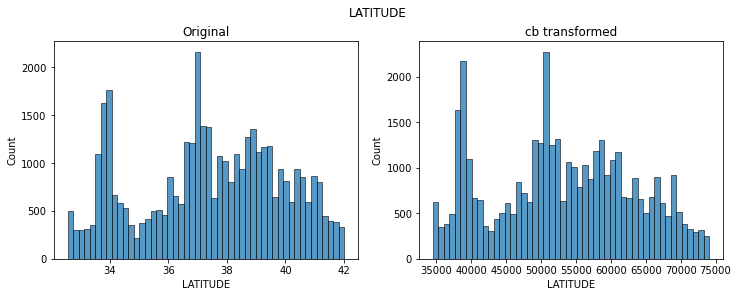

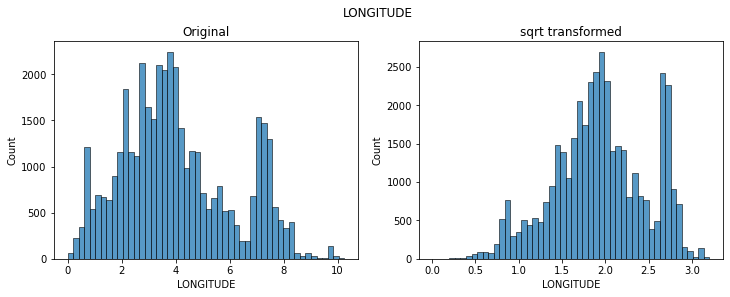

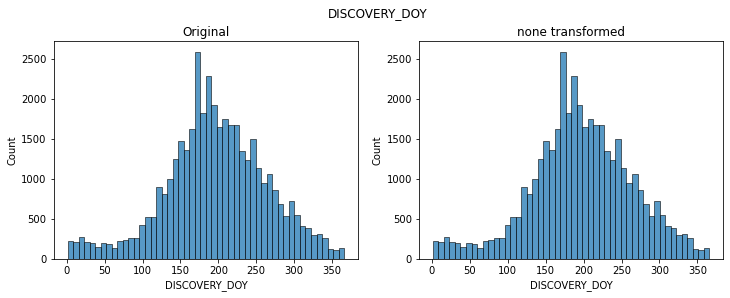

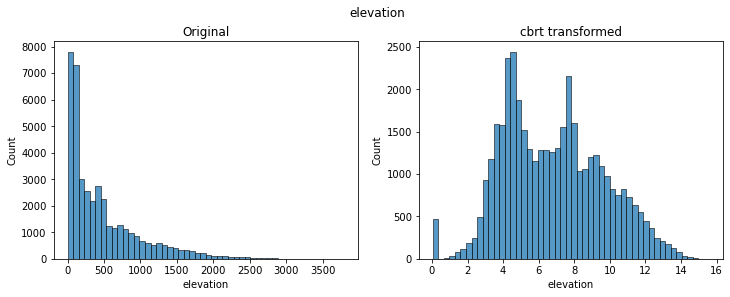

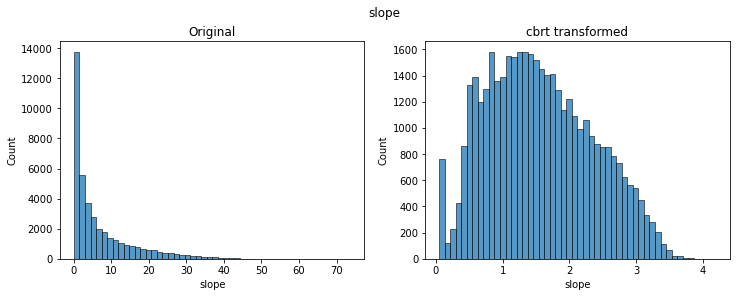

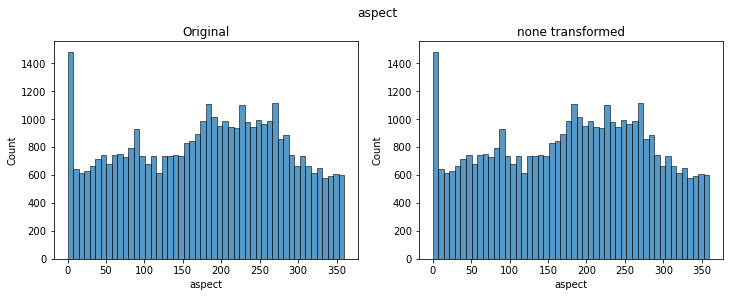

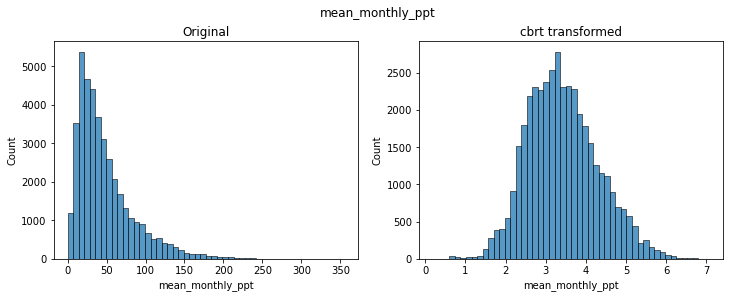

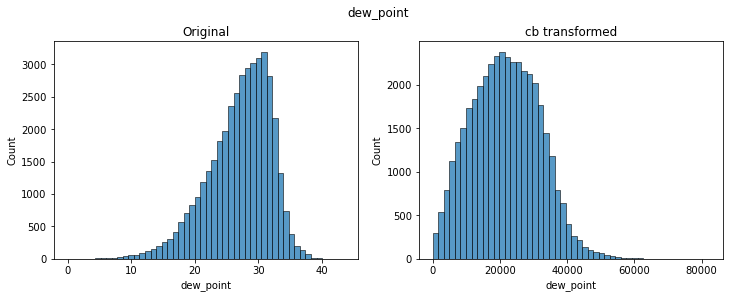

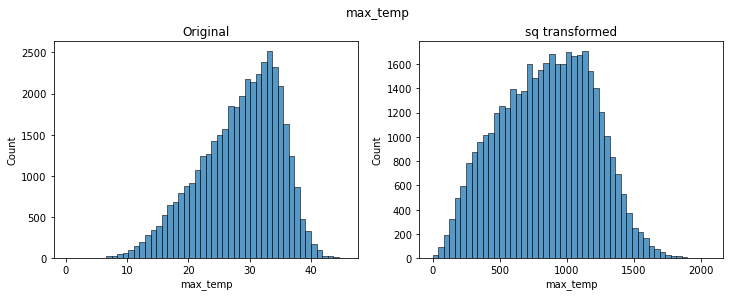

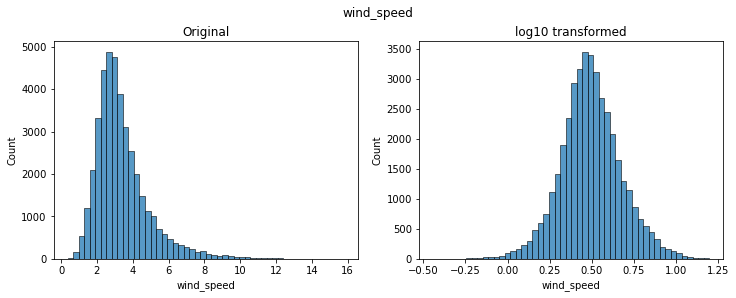

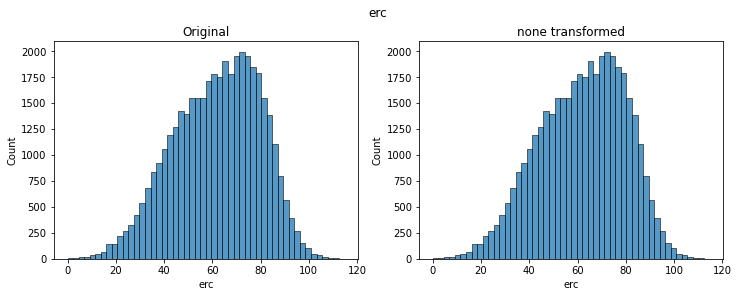

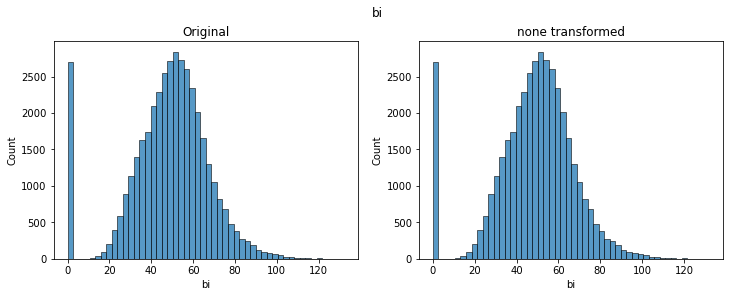

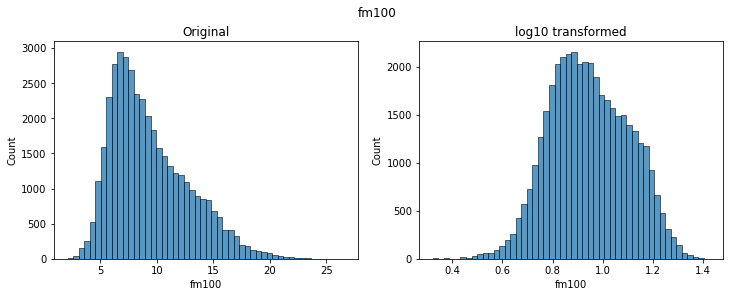

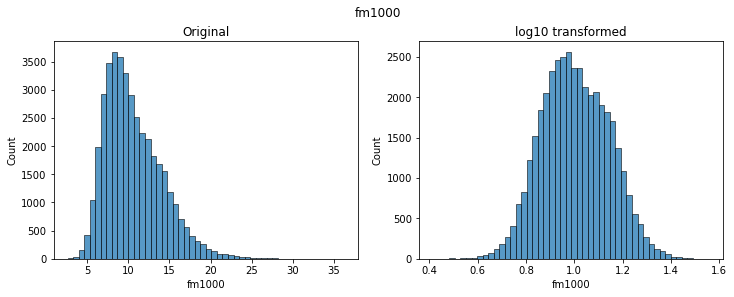

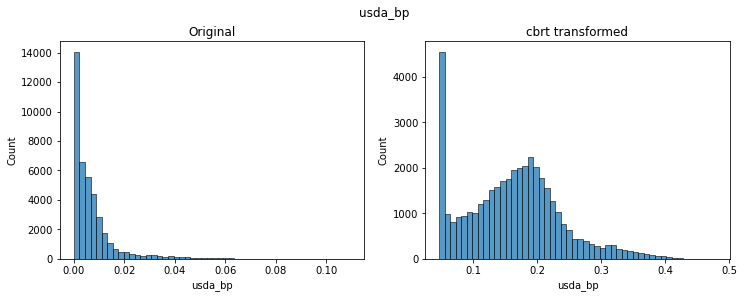

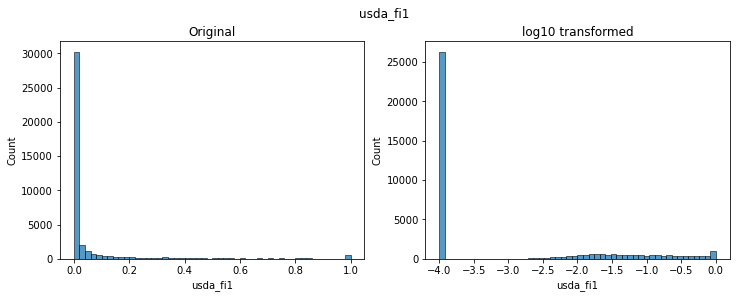

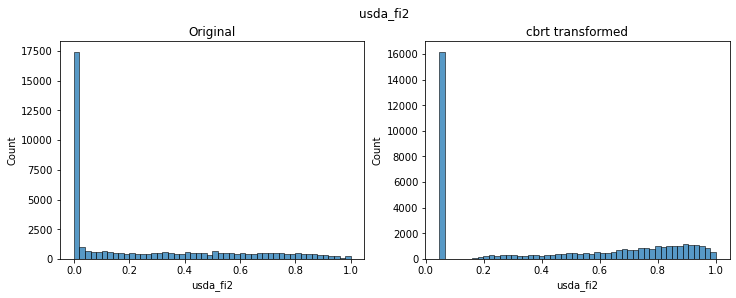

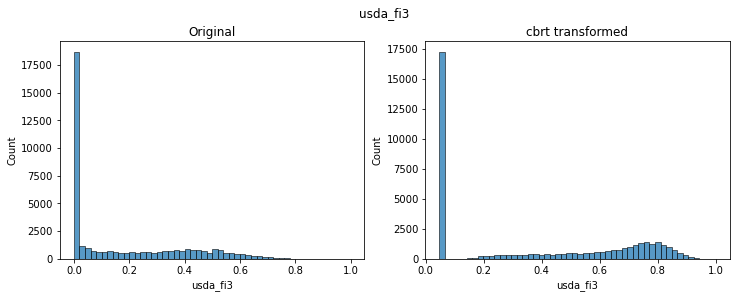

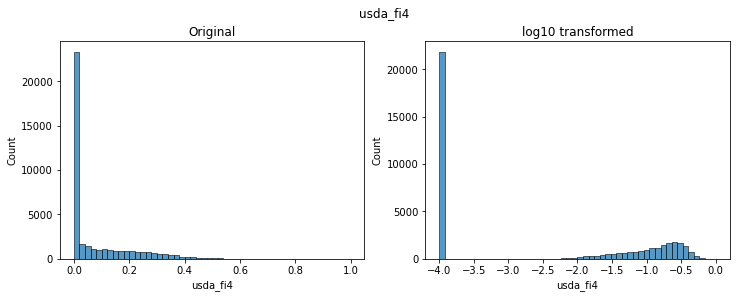

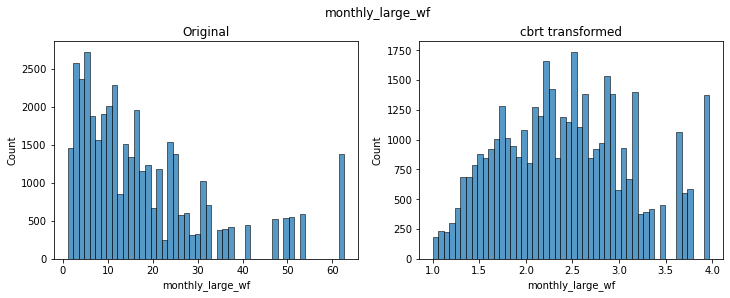

In [46]:
# for each continuous feature, we do a visual inspection comparing the original distribution to the transformed
# distribution. Choosing the transformation that reduces skew the most makes sense, but it is important to make sure
# that the transformation aren't producing problematic results. In general, we want to confirm that transformed
# distribution is actually closer to a normal distribution.

for col in wfs_trans.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

    sns.histplot(x=col, data=wfs_no_zeros, bins=50, ax=ax1)
    ax1.set_title('Original')

    sns.histplot(x=col, data=wfs_trans, bins=50, ax=ax2)
    title = wfs_noZ_describe.loc[col,'best_trans']
    ax2.set_title(f'{title} transformed')

    fig.suptitle(col, y=1.0) 

    plt.show();

In [47]:
wfs_trans.head()

,LATITUDE,LONGITUDE,DISCOVERY_DOY,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,63268.140847,2.023119,45,11.845419,2.414584,45.13996,3.940440,3370.826396,185.948290,0.606454,31.053229,29.961724,1.126366,1.268039,0.143987,-0.969631,0.793753,0.685078,-1.145518,1.310371
4,62997.282739,1.954257,37,11.635882,1.846491,167.01350,3.941304,1128.748466,148.920193,0.678806,45.308881,44.245637,1.027967,1.149550,0.187674,-4.000000,0.313695,0.639588,-0.557484,1.310371
5,62985.409154,1.975112,37,11.464129,1.163283,324.95300,3.646062,1057.364686,156.367873,0.652441,42.349519,40.321435,1.046028,1.171934,0.177523,-1.438136,0.851914,0.689204,-1.737976,1.310371
6,64632.740505,1.880443,57,10.257326,2.775995,268.48042,4.728582,2894.485059,124.099586,0.758136,17.560101,0.000101,1.169783,1.300238,0.211271,-4.000000,0.320970,0.784935,-0.578666,1.310371
7,62732.461313,1.960856,55,11.107087,1.308573,254.73255,4.313399,3051.662747,106.313768,0.734011,45.714009,48.972016,1.057925,1.162887,0.171762,-1.696804,0.920556,0.584901,-4.000000,1.310371


## Identifying Intercolinearity

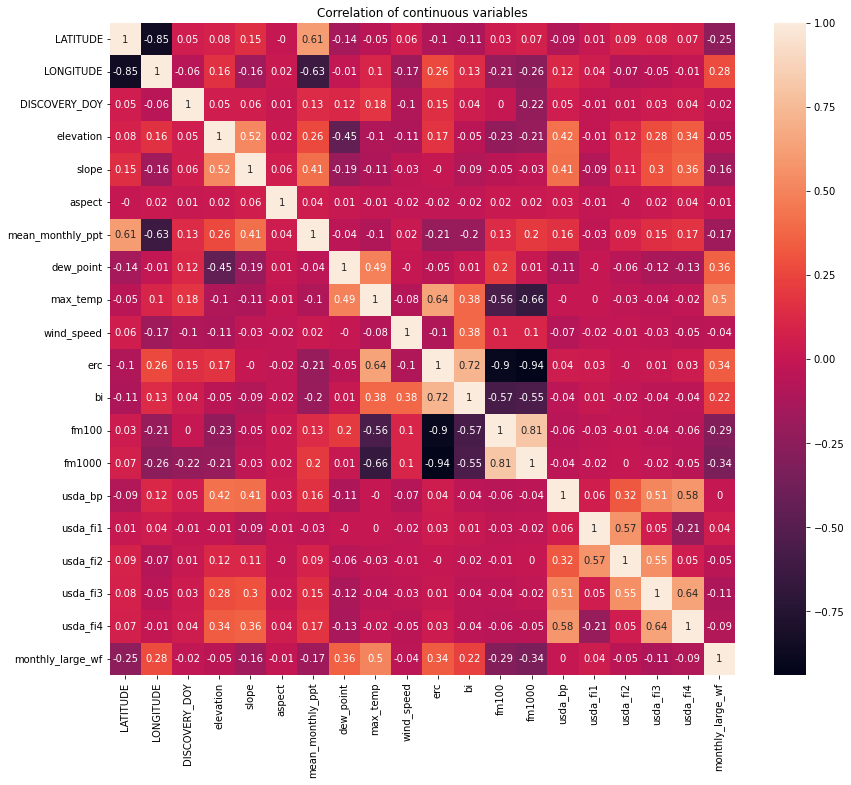

In [48]:
# checking correlation matrix for highly correlated variables.
# For any variables that are >0.8 correlated, one should be removed

# Make a heatmap of the data
plt.subplots(figsize=(14,12))
sns.heatmap(round(wfs_trans.corr(),2), annot=True)
plt.title('Correlation of continuous variables');

In [19]:
# convert target feature to a binary variable (small vs large wildfires)
large_fire_classes = ['E','F','G']
binary_target = wfs['FIRE_SIZE_CLASS'].apply(lambda t: 1 if t in large_fire_classes else 0)

In [20]:
# to determine which correlated features to drop/keep, test strength between features and the target variable 
from sklearn.linear_model import LogisticRegression

def compare_coeff(feature_list):
    
    dict_coeff = {}
    
    for feat in feature_list:
    
        logreg = LogisticRegression(class_weight='balanced')
        logreg.fit(wfs[feat].to_numpy().reshape(-1, 1), binary_target)
        
        coeff = round(logreg.coef_[0][0],4)
        
        #print(f'{feat}: {coeff}')
        
        dict_coeff[feat] = coeff
    
    df = pd.DataFrame(pd.Series(dict_coeff), columns=['Coeff'])
    df.index.names = ['Features']
    df
    
    return df

In [21]:
# latitude and longitude are highlighly correlated.
correlated_features = ['LATITUDE', 'LONGITUDE']
test_dict = compare_coeff(correlated_features)
test_dict

,Coeff
Features,
LATITUDE,0.0094
LONGITUDE,0.0342


We'll keep `LONGITUDE` and drop `LATITUDE`

In [22]:
# fm100, fm1000, and erc are highly correlated
correlated_features = ['erc', 'fm100', 'fm1000']
compare_coeff(correlated_features)

,Coeff
Features,
erc,0.0328
fm100,-0.2299
fm1000,-0.2074


We'll keep `fm100` and drop `erc` and `fm1000`

In [23]:
#see coefficients for all variables
correlated_features = wfs_trans.columns
compare_coeff(correlated_features).sort_values('Coeff', ascending=False)

,Coeff
Features,
usda_bp,14.8484
usda_fi3,1.3656
usda_fi4,1.2483
usda_fi2,0.8479
slope,0.0700
max_temp,0.0407
LONGITUDE,0.0342
erc,0.0328
wind_speed,0.0299


## Simplify Categorical Categories

Here we simplify categorical variables so their column names when dummy encoded won't be too long (dummy encoding happens within pipelines in the next notebook).

In [25]:
def see_uniques(df):
    ''' print unique values of each obj column'''
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'----- {col} -----')
            print(f'Num categories: {df[col].nunique()}')
            print(df[col].unique())

In [50]:
#simplifying category names 
#wfs_cat = wfs[exp_cat]
for col in exp_cat[1:]:
    
    wfs.loc[:,col] = wfs_cat[col].str.replace(' ', '_')
    wfs.loc[:,col] = wfs_cat[col].str.replace('/', '_')
    wfs.loc[:,col] = wfs_cat[col].str.replace('California', 'CA')
    wfs.loc[:,col] = wfs_cat[col].str.replace('CALIFORNIA', 'CA')
    wfs.loc[:,col] = wfs_cat[col].str.replace('Southern', 'S')
    wfs.loc[:,col] = wfs_cat[col].str.replace('Northern', 'N')
    wfs.loc[:,col] = wfs_cat[col].str.replace('North', 'N')
    wfs.loc[:,col] = wfs_cat[col].str.replace('Eastern', 'E')
    wfs.loc[:,col] = wfs_cat[col].str.replace('WESTERN', 'W')
    wfs.loc[:,col] = wfs_cat[col].str.replace('WEST', 'W')
    
see_uniques(wfs)

----- FPA_ID -----
Num categories: 40603
['FS-1432089' 'FS-1447474' 'FS-1447538' ... 'SFO-2014CACDFLNU000001'
 'SFO-2013CACDFTGU016621' '2010CAIRS13732348']
----- FIRE_NAME -----
Num categories: 22976
['SUGARLOAF' 'VISTA' 'SEMAPHORE' ... 'COUNTY ROAD 79A  / COUNTY' 'HOSTEL'
 'DEAD']
----- SOURCE_REPORTING_UNIT_NAME -----
Num categories: 179
['Plumas National Forest' 'Lassen-Modoc Unit'
 'Shasta-Trinity National Forest' 'Northern California District'
 'Shasta-Trinity Unit' 'Norcal Region' 'Klamath National Forest'
 'Siskiyou Unit' 'NorCal Region' 'Six Rivers National Forest'
 'Hoopa Valley Tribe' 'Humboldt-Del Norte Unit'
 'Northern California Agency' 'Angeles National Forest'
 'Santa Monica Mountains National Recreation Area'
 'Los Angeles County Fire Department'
 'SANTA MONICA MOUNTAINS NATL RECR AREA'
 'Santa Monica Mountains Natl Recr Area' 'California Desert District'
 'Los Angeles City Fire Department' 'Eldorado National Forest'
 'Lake Tahoe Basin Management Unit' 'Stanislaus Nati

## Merge

Merge the transformed continuous variables and categorical variables back together.

In [52]:
wfs_preprocessed = pd.concat([wfs_trans, wfs[exp_cat]], axis=1)
wfs_preprocessed

,LATITUDE,LONGITUDE,DISCOVERY_DOY,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,...,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf,DISCOVERY_MONTH,WHR10NAME,aspect_cat,NA_L2NAME,US_L3NAME
1,63268.140847,2.023119,45,11.845419,2.414584,45.139960,3.940440,3370.826396,185.948290,0.606454,...,-0.969631,0.793753,0.685078,-1.145518,1.310371,2,Shrub,NE,W_CORDILLERA,Sierra_Nevada
4,62997.282739,1.954257,37,11.635882,1.846491,167.013500,3.941304,1128.748466,148.920193,0.678806,...,-4.000000,0.313695,0.639588,-0.557484,1.310371,2,Conifer,S,W_CORDILLERA,Sierra_Nevada
5,62985.409154,1.975112,37,11.464129,1.163283,324.953000,3.646062,1057.364686,156.367873,0.652441,...,-1.438136,0.851914,0.689204,-1.737976,1.310371,2,Hardwood,NW,W_CORDILLERA,Sierra_Nevada
6,64632.740505,1.880443,57,10.257326,2.775995,268.480420,4.728582,2894.485059,124.099586,0.758136,...,-4.000000,0.320970,0.784935,-0.578666,1.310371,2,Conifer,W,W_CORDILLERA,Sierra_Nevada
7,62732.461313,1.960856,55,11.107087,1.308573,254.732550,4.313399,3051.662747,106.313768,0.734011,...,-1.696804,0.920556,0.584901,-4.000000,1.310371,2,Herbaceous,W,W_CORDILLERA,Sierra_Nevada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,54676.936376,1.379092,53,1.325739,0.046416,0.000100,3.262200,19809.396973,287.350958,0.480123,...,-4.000000,0.046416,0.046416,-4.000000,1.000000,2,Urban,N,MEDITERRANEAN_CA,Central_CA_Foothills_and_Coastal_Mountains
83534,56169.346024,1.506464,13,4.444428,1.805576,56.448598,2.296524,12503.945832,266.496309,0.310306,...,-4.000000,0.699705,0.790113,-0.821642,1.259921,1,Herbaceous,NE,MEDITERRANEAN_CA,Central_CA_Foothills_and_Coastal_Mountains
83535,56627.894981,1.529466,1,8.031076,2.529796,201.643440,2.321341,4973.528458,350.705860,0.022281,...,-4.000000,0.775711,0.811011,-4.000000,1.259921,1,Shrub,S,MEDITERRANEAN_CA,Central_CA_Foothills_and_Coastal_Mountains
83537,62365.554436,1.551972,340,3.341027,0.046416,0.000100,2.384624,7238.610752,239.002755,0.366826,...,-0.079129,0.550432,0.046416,-4.000000,1.000000,12,Agriculture,N,MEDITERRANEAN_CA,Central_CA_Valley


## Cyclical Variables

Day of the year and aspect are actually cyclic features where the maximum value is actually close in meaning to the minimum value. Transforming cyclic features into twin sin/cosine harmonic features is one way to capture this relationship.

https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes

In [64]:
# define fuctions for creating cyclical variables
def make_harmonic_features_sin(value, period):
    value *= 2 * np.pi / period 
    return round(np.sin(value),5)

def make_harmonic_features_cos(value, period):
    value *= 2 * np.pi / period 
    return round(np.cos(value),5)


In [66]:
# create dual columns for aspect
wfs_preprocessed['aspect_cos'] = wfs_preprocessed.apply(lambda x: make_harmonic_features_cos(value = x['aspect'], period=360), axis=1)
wfs_preprocessed['aspect_sin'] = wfs_preprocessed.apply(lambda x: make_harmonic_features_sin(value = x['aspect'], period=360), axis=1)

In [69]:
# create dual columns for DISCOVERY_DOY
wfs_preprocessed['DISCOVERY_DOY_cos'] = wfs_preprocessed.apply(lambda x: make_harmonic_features_cos(value = x['DISCOVERY_DOY'], period=365), axis=1)
wfs_preprocessed['DISCOVERY_DOY_sin'] = wfs_preprocessed.apply(lambda x: make_harmonic_features_sin(value = x['DISCOVERY_DOY'], period=365), axis=1)

In [70]:
wfs_preprocessed.head()

,LATITUDE,LONGITUDE,DISCOVERY_DOY,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,...,monthly_large_wf,DISCOVERY_MONTH,WHR10NAME,aspect_cat,NA_L2NAME,US_L3NAME,aspect_cos,aspect_sin,DISCOVERY_DOY_cos,DISCOVERY_DOY_sin
1,63268.140847,2.023119,45,11.845419,2.414584,45.13996,3.940440,3370.826396,185.948290,0.606454,...,1.310371,2,Shrub,NE,W_CORDILLERA,Sierra_Nevada,0.70538,0.70883,0.71467,0.69946
4,62997.282739,1.954257,37,11.635882,1.846491,167.01350,3.941304,1128.748466,148.920193,0.678806,...,1.310371,2,Conifer,S,W_CORDILLERA,Sierra_Nevada,-0.97442,0.22472,0.80393,0.59473
5,62985.409154,1.975112,37,11.464129,1.163283,324.95300,3.646062,1057.364686,156.367873,0.652441,...,1.310371,2,Hardwood,NW,W_CORDILLERA,Sierra_Nevada,0.81868,-0.57425,0.80393,0.59473
6,64632.740505,1.880443,57,10.257326,2.775995,268.48042,4.728582,2894.485059,124.099586,0.758136,...,1.310371,2,Conifer,W,W_CORDILLERA,Sierra_Nevada,-0.02652,-0.99965,0.55602,0.83117
7,62732.461313,1.960856,55,11.107087,1.308573,254.73255,4.313399,3051.662747,106.313768,0.734011,...,1.310371,2,Herbaceous,W,W_CORDILLERA,Sierra_Nevada,-0.26333,-0.96471,0.58430,0.81154


## Export

In [72]:
wfs_preprocessed.to_csv('Datasets/wfs_preprocessed.csv')
wfs['FIRE_SIZE_CLASS'].to_csv('Datasets/wfs_preprocessed_y.csv')